In [1]:
import torch
import pandas as pd

In [2]:
artists = pd.read_csv('/kaggle/input/best-artworks-of-all-time/artists.csv')
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [3]:
from PIL import Image
import os 

In [4]:
img_path = '/kaggle/input/best-artworks-of-all-time/resized/resized'
all_images = os.listdir(img_path)
all_images_path = []
for imgs in all_images:
    all_images_path.append(os.path.join(img_path, imgs))

In [5]:
all_images_path[0]

'/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_132.jpg'

In [6]:
img = Image.open(all_images_path[0])

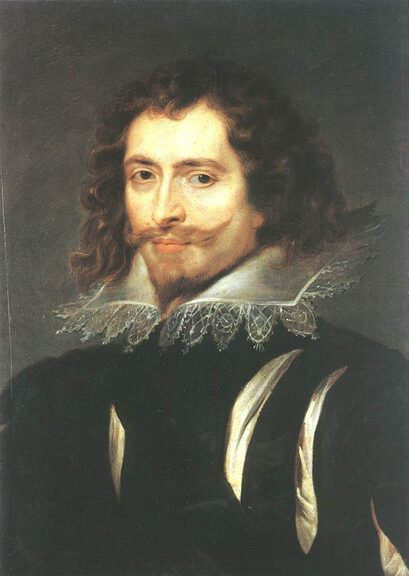

In [7]:
from IPython.display import display
display(img)

In [8]:
img.size

(409, 576)

In [9]:
from torchvision import transforms

In [10]:
import torch

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()

        self.loc = nn.Parameter(torch.zeros(1, in_channel, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, in_channel, 1, 1))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            flatten = input.permute(1, 0, 2, 3).contiguous().view(input.shape[1], -1)
            mean = (
                flatten.mean(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )
            std = (
                flatten.std(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )

            self.loc.data.copy_(-mean)
            self.scale.data.copy_(1 / (std + 1e-6))

    def forward(self, input):
        _, _, height, width = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)

        log_abs = logabs(self.scale)

        logdet = height * width * torch.sum(log_abs)

        if self.logdet:
            return self.scale * (input + self.loc), logdet

        else:
            return self.scale * (input + self.loc)

    def reverse(self, output):
        return output / self.scale - self.loc

In [13]:
class InvConv2d(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = torch.randn(in_channel, in_channel)
        q, _ = torch.qr(weight)
        weight = q.unsqueeze(2).unsqueeze(3)
        self.weight = nn.Parameter(weight)

    def forward(self, input):
        _, _, height, width = input.shape

        out = F.conv2d(input, self.weight)
        logdet = (
            height * width * torch.slogdet(self.weight.squeeze().double())[1].float()
        )

        return out, logdet

    def reverse(self, output):
        return F.conv2d(
            output, self.weight.squeeze().inverse().unsqueeze(2).unsqueeze(3)
        )


In [14]:
class InvConv2dLU(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = np.random.randn(in_channel, in_channel)
        q, _ = la.qr(weight)
        w_p, w_l, w_u = la.lu(q.astype(np.float32))
        w_s = np.diag(w_u)
        w_u = np.triu(w_u, 1)
        u_mask = np.triu(np.ones_like(w_u), 1)
        l_mask = u_mask.T

        w_p = torch.from_numpy(w_p)
        w_l = torch.from_numpy(w_l)
        w_s = torch.from_numpy(w_s)
        w_u = torch.from_numpy(w_u)

        self.register_buffer("w_p", w_p)
        self.register_buffer("u_mask", torch.from_numpy(u_mask))
        self.register_buffer("l_mask", torch.from_numpy(l_mask))
        self.register_buffer("s_sign", torch.sign(w_s))
        self.register_buffer("l_eye", torch.eye(l_mask.shape[0]))
        self.w_l = nn.Parameter(w_l)
        self.w_s = nn.Parameter(logabs(w_s))
        self.w_u = nn.Parameter(w_u)

    def forward(self, input):
        _, _, height, width = input.shape

        weight = self.calc_weight()

        out = F.conv2d(input, weight)
        logdet = height * width * torch.sum(self.w_s)

        return out, logdet

    def calc_weight(self):
        weight = (
            self.w_p
            @ (self.w_l * self.l_mask + self.l_eye)
            @ ((self.w_u * self.u_mask) + torch.diag(self.s_sign * torch.exp(self.w_s)))
        )

        return weight.unsqueeze(2).unsqueeze(3)

    def reverse(self, output):
        weight = self.calc_weight()

        return F.conv2d(output, weight.squeeze().inverse().unsqueeze(2).unsqueeze(3))

In [15]:
class ZeroConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channel, out_channel, 3, padding=0)
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()
        self.scale = nn.Parameter(torch.zeros(1, out_channel, 1, 1))

    def forward(self, input):
        out = F.pad(input, [1, 1, 1, 1], value=1)
        out = self.conv(out)
        out = out * torch.exp(self.scale * 3)

        return out

In [16]:
class AffineCoupling(nn.Module):
    def __init__(self, in_channel, filter_size=512, affine=True):
        super().__init__()

        self.affine = affine

        self.net = nn.Sequential(
            nn.Conv2d(in_channel // 2, filter_size, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_size, filter_size, 1),
            nn.ReLU(inplace=True),
            ZeroConv2d(filter_size, in_channel if self.affine else in_channel // 2),
        )

        self.net[0].weight.data.normal_(0, 0.05)
        self.net[0].bias.data.zero_()

        self.net[2].weight.data.normal_(0, 0.05)
        self.net[2].bias.data.zero_()

    def forward(self, input):
        in_a, in_b = input.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(in_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # out_a = s * in_a + t
            out_b = (in_b + t) * s

            logdet = torch.sum(torch.log(s).view(input.shape[0], -1), 1)

        else:
            net_out = self.net(in_a)
            out_b = in_b + net_out
            logdet = None

        return torch.cat([in_a, out_b], 1), logdet

    def reverse(self, output):
        out_a, out_b = output.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(out_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # in_a = (out_a - t) / s
            in_b = out_b / s - t

        else:
            net_out = self.net(out_a)
            in_b = out_b - net_out

        return torch.cat([out_a, in_b], 1)

In [17]:
class Flow(nn.Module):
    def __init__(self, in_channel, affine=True, conv_lu=True):
        super().__init__()

        self.actnorm = ActNorm(in_channel)

        if conv_lu:
            self.invconv = InvConv2dLU(in_channel)

        else:
            self.invconv = InvConv2d(in_channel)

        self.coupling = AffineCoupling(in_channel, affine=affine)

    def forward(self, input):
        out, logdet = self.actnorm(input)
        out, det1 = self.invconv(out)
        out, det2 = self.coupling(out)

        logdet = logdet + det1
        if det2 is not None:
            logdet = logdet + det2

        return out, logdet

    def reverse(self, output):
        input = self.coupling.reverse(output)
        input = self.invconv.reverse(input)
        input = self.actnorm.reverse(input)

        return input

In [18]:
def gaussian_log_p(x, mean, log_sd):
    return -0.5 * log(2 * pi) - log_sd - 0.5 * (x - mean) ** 2 / torch.exp(2 * log_sd)

In [19]:
def gaussian_sample(eps, mean, log_sd):
    return mean + torch.exp(log_sd) * eps

In [20]:
class Block(nn.Module):
    def __init__(self, in_channel, n_flow, split=True, affine=True, conv_lu=True):
        super().__init__()
        squeeze_dim = in_channel * 4

        self.flows = nn.ModuleList()
        for i in range(n_flow):
            self.flows.append(Flow(squeeze_dim, affine=affine, conv_lu=conv_lu))

        self.split = split

        if split:
            self.prior = ZeroConv2d(in_channel * 2, in_channel * 4)

        else:
            self.prior = ZeroConv2d(in_channel * 4, in_channel * 8)

    def forward(self, input):
        b_size, n_channel, height, width = input.shape
        squeezed = input.view(b_size, n_channel, height // 2, 2, width // 2, 2)
        squeezed = squeezed.permute(0, 1, 3, 5, 2, 4)
        out = squeezed.contiguous().view(b_size, n_channel * 4, height // 2, width // 2)

        logdet = 0

        for flow in self.flows:
            out, det = flow(out)
            logdet = logdet + det

        if self.split:
            out, z_new = out.chunk(2, 1)
            mean, log_sd = self.prior(out).chunk(2, 1)
            log_p = gaussian_log_p(z_new, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)

        else:
            zero = torch.zeros_like(out)
            mean, log_sd = self.prior(zero).chunk(2, 1)
            log_p = gaussian_log_p(out, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)
            z_new = out

        return out, logdet, log_p, z_new

    def reverse(self, output, eps=None, reconstruct=False):
        input = output

        if reconstruct:
            if self.split:
                input = torch.cat([output, eps], 1)

            else:
                input = eps

        else:
            if self.split:
                mean, log_sd = self.prior(input).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = torch.cat([output, z], 1)

            else:
                zero = torch.zeros_like(input)
                # zero = F.pad(zero, [1, 1, 1, 1], value=1)
                mean, log_sd = self.prior(zero).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = z

        for flow in self.flows[::-1]:
            input = flow.reverse(input)

        b_size, n_channel, height, width = input.shape

        unsqueezed = input.view(b_size, n_channel // 4, 2, 2, height, width)
        unsqueezed = unsqueezed.permute(0, 1, 4, 2, 5, 3)
        unsqueezed = unsqueezed.contiguous().view(
            b_size, n_channel // 4, height * 2, width * 2
        )

        return unsqueezed


In [21]:
class Glow(nn.Module):
    def __init__(
        self, in_channel, n_flow, n_block, affine=True, conv_lu=True
    ):
        super().__init__()

        self.blocks = nn.ModuleList()
        n_channel = in_channel
        for i in range(n_block - 1):
            self.blocks.append(Block(n_channel, n_flow, affine=affine, conv_lu=conv_lu))
            n_channel *= 2
        self.blocks.append(Block(n_channel, n_flow, split=False, affine=affine))

    def forward(self, input):
        log_p_sum = 0
        logdet = 0
        out = input
        z_outs = []

        for block in self.blocks:
            out, det, log_p, z_new = block(out)
            z_outs.append(z_new)
            logdet = logdet + det

            if log_p is not None:
                log_p_sum = log_p_sum + log_p

        return log_p_sum, logdet, z_outs

    def reverse(self, z_list, reconstruct=False):
        for i, block in enumerate(self.blocks[::-1]):
            if i == 0:
                input = block.reverse(z_list[-1], z_list[-1], reconstruct=reconstruct)

            else:
                input = block.reverse(input, z_list[-(i + 1)], reconstruct=reconstruct)

        return input

In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
import torch
from torch import nn, optim
from torch.autograd import Variable, grad
import numpy as np
from math import log, sqrt, pi
import torch
from torch import nn
from torch.nn import functional as F
from math import log, pi, exp
import numpy as np
from scipy import linalg as la

In [24]:
def calc_z_shapes(n_channel, input_size, n_flow, n_block):
    z_shapes = []

    for i in range(n_block - 1):
        input_size //= 2
        n_channel *= 2

        z_shapes.append((n_channel, input_size, input_size))

    input_size //= 2
    z_shapes.append((n_channel * 4, input_size, input_size))

    return z_shapes

In [25]:
def calc_loss(log_p, logdet, image_size, n_bins):
    # log_p = calc_log_p([z_list])
    n_pixel = image_size * image_size * 3

    loss = -log(n_bins) * n_pixel
    loss = loss + logdet + log_p

    return (
        (-loss / (log(2) * n_pixel)).mean(),
        (log_p / (log(2) * n_pixel)).mean(),
        (logdet / (log(2) * n_pixel)).mean(),
    )

In [26]:
class ArtDataset(Dataset):
    def __init__(self, img_dir, image_size=256):
        self.dir = img_dir
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
    def __len__(self):
        return len(self.dir)
    def __getitem__(self, idx):
        img_path = self.dir[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
            return image 
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return 

In [27]:
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('samples', exist_ok=True)

In [28]:
full_dataset = ArtDataset(
    img_dir = all_images_path,
    image_size=64
)

In [29]:
len(full_dataset)

8683

In [30]:
def sample_data(dataset, batch_size, image_size):
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
    loader = iter(loader)

    while True:
        try:
            yield next(loader)

        except StopIteration:
            loader = DataLoader(
                dataset, shuffle=True, batch_size=batch_size, num_workers=4
            )
            loader = iter(loader)
            yield next(loader)

In [31]:
from torchvision import utils

In [32]:
import wandb

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [33]:
# !pip install -U wandb

In [34]:
import wandb
wandb.__version__

'0.22.2'

In [121]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
KEY = user_secrets.get_secret("WANDB_API_KEY")

In [122]:
wandb.login(key=KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [36]:
wandb.init(project='NF-Audio', name='run-10')

In [46]:
def train(args, model, optimizer, t_dataset):
    dataset = iter(sample_data(t_dataset, args.batch, args.img_size))
    n_bins = 2.0 ** args.n_bits

    z_sample = []
    z_shapes = calc_z_shapes(3, args.img_size, args.n_flow, args.n_block)
    for z in z_shapes:
        z_new = torch.randn(args.n_sample, *z) * args.temp
        z_sample.append(z_new.to(device))

    with tqdm(range(args.epochs+1)) as pbar:
        for i in pbar:
            image= next(dataset)
            image = image.to(device)

            image = image * 255

            if args.n_bits < 8:
                image = torch.floor(image / 2 ** (8 - args.n_bits))

            image = image / n_bins - 0.5

            log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)

            logdet = logdet.mean()

            loss, log_p, log_det = calc_loss(log_p, logdet, args.img_size, n_bins)
            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            # warmup_lr = args.lr * min(1, i * batch_size / (50000 * 10))
            if i < 1000:
                warmup_lr = args.lr * (i / 1000)
            else:
                warmup_lr = args.lr
                
            warmup_lr = args.lr
            optimizer.param_groups[0]["lr"] = warmup_lr
            optimizer.step()

            pbar.set_description(
                f"Loss: {loss.item():.5f}; logP: {log_p.item():.5f}; logdet: {log_det.item():.5f}; lr: {warmup_lr:.7f}"
            )
            
            wandb.log({'Loss': loss.item(),
                      'LogP': log_p.item(),
                      'LogDet': log_det.item()})
            
            if i % 1000 == 0:
                with torch.no_grad():
                    samples = model.reverse(z_sample)
                    samples = samples + 0.5   # [-0.5,0.5] → [0,1]
                    samples = torch.clamp(samples, 0, 1)
                    model.train()
                    
                    utils.save_image(
                        samples,
                        f"samples/{str(i + 1).zfill(6)}.png",
                        normalize=False,
                        nrow=10,
                    )

            if i % 10000 == 0:
                torch.save(
                    model.state_dict(), f"checkpoints/model_{str(i + 1).zfill(6)}.pt"
                )
                torch.save(
                    optimizer.state_dict(), f"checkpoints/optim_{str(i + 1).zfill(6)}.pt"
                )
                torch.save(model, 'final_model.pth')
    torch.save(model, 'final_model.pth')
    wandb.finish()

In [47]:
class Args:
    def __init__(self):
        self.batch = 16
        self.epochs = 20000 #500000
        self.n_flow = 32
        self.n_block=4
        self.affine = True
        self.n_bits = 8
        self.lr=5e-5
        self.img_size=64
        self.temp=0.7
        self.n_sample=20

In [48]:
args = Args()

In [49]:
logabs = lambda x: torch.log(torch.abs(x))

In [50]:
device = 'cuda'

In [96]:
!ls -la checkpoints

total 1762368
drwxr-xr-x 2 root root      4096 Jan 20 19:38 .
drwxr-xr-x 7 root root      4096 Jan 20 22:35 ..
-rw-r--r-- 1 root root 305083109 Jan 20 17:24 model_000001.pt
-rw-r--r-- 1 root root 305083109 Jan 20 19:38 model_010001.pt
-rw-r--r-- 1 root root 597229573 Jan 20 17:24 optim_000001.pt
-rw-r--r-- 1 root root 597229573 Jan 20 19:38 optim_010001.pt


In [51]:
model = Glow(
    3, args.n_flow, args.n_block
).to(device)

In [128]:
# state_dict = torch.load(
#     "/kaggle/working/checkpoints/model_000001.pt",
#     map_location="cpu"  # important on Kaggle
# )

In [129]:
# model.load_state_dict(state_dict)

In [52]:
optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [131]:
# optim_state = torch.load(
#     "/kaggle/working/checkpoints/optim_000001.pt",
#     map_location="cpu"  # important on Kaggle
# )

In [132]:
# optimizer.load_state_dict(optim_state)

In [53]:
from tqdm import tqdm

In [54]:
train(args, model, optimizer, full_dataset)

Loss: 4.83685; logP: -2.15226; logdet: 5.31541; lr: 0.0000500: 100%|██████████| 20001/20001 [4:56:46<00:00,  1.12it/s]  


LogDet,▁▁▃▄▂▄▄▅▄▅▆▅▆▆▅▆▅▆▆▆▆▆▅▇▆▇▆▇▆▇█▆▆▇▇▇▇▆▇▇
LogP,▆█▆▇█▆▆▄▄▅▄▄▆▅▁▄▆▄▆▃▆▄▄▅▁▅▆▃▄▄▅▃▇▅▆▄▅▄▄▄
Loss,█▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂
LogDet,5.31541
LogP,-2.15226
Loss,4.83685


In [55]:
!zip -r /kaggle/working/samples.zip samples
!zip -r /kaggle/working/checkpoints.zip checkpoints

  adding: samples/ (stored 0%)
  adding: samples/014001.png (deflated 0%)
  adding: samples/017001.png (deflated 0%)
  adding: samples/012001.png (deflated 0%)
  adding: samples/009001.png (deflated 0%)
  adding: samples/010001.png (deflated 0%)
  adding: samples/008001.png (deflated 0%)
  adding: samples/015001.png (deflated 0%)
  adding: samples/005001.png (deflated 0%)
  adding: samples/019001.png (deflated 0%)
  adding: samples/007001.png (deflated 0%)
  adding: samples/020001.png (deflated 0%)
  adding: samples/018001.png (deflated 0%)
  adding: samples/001001.png (deflated 0%)
  adding: samples/006001.png (deflated 0%)
  adding: samples/016001.png (deflated 0%)
  adding: samples/002001.png (deflated 0%)
  adding: samples/000001.png (deflated 0%)
  adding: samples/003001.png (deflated 0%)
  adding: samples/013001.png (deflated 0%)
  adding: samples/004001.png (deflated 0%)
  adding: samples/011001.png (deflated 0%)
  adding: checkpoints/ (stored 0%)
  adding: checkpoints/optim_000

In [70]:
import cv2
from PIL import Image
from scipy.io import wavfile
from moviepy.editor import VideoFileClip, AudioFileClip
import os

In [87]:
def extract_visual_features(image):
    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image
    # hsv->hue, saturation and Value(Brightness)
    hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    # Dominant Hues
    hue_hist = np.histogram(hsv[:,:,0], bins=12, range=(0, 180))[0]
    dominant_hues = hue_hist/(hue_hist.sum()+1e-8)

    #Avg Saturation
    avg_sat = hsv[:,:,1].mean()/255.0
    avg_brightness = hsv[:,:,2].mean()/255.0

    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    #edge density
    edges = cv2.Canny(gray, 50, 150)
    edge_density=edges.sum() / (edges.shape[0] * edges.shape[1] * 255.0)

    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    texture_complexity = np.sqrt(gx**2+gy**2).mean()/255.0

    spatial_var = np.var(gray)/(255.0**2)
    # symmetry
    left_half = gray[:, :gray.shape[1]//2]
    right_half = np.flip(gray[:, gray.shape[1]//2:], axis=1)
    min_width = min(left_half.shape[1], right_half.shape[1])
    symmetry = 1.0 - np.abs(left_half[:, :min_width] - right_half[:, :min_width]).mean() / 255.0

    return {
        'dominant_hues': dominant_hues,
        'saturation': float(avg_sat),
        'brightness': float(avg_brightness),
        'edge_density': float(edge_density),
        'texture_complexity': float(texture_complexity),
        'spatial_variance': float(spatial_var),
        'symmetry': float(symmetry)
    }


In [59]:
def features2audio_param(features):
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    base_octave = 4

    top_hues = np.argsort(features['dominant_hues'])[-3:][::-1]
    frequencies=[]
    
    for hue_idx in top_hues:
        semitones_from_a4 = (hue_idx - 9) + (base_octave-4)*12
        freq = 440*(2**(semitones_from_a4/12))
        frequencies.append(freq)
    volume = features['brightness']*0.6 + features['saturation']*0.4
    volume = np.clip(volume, 0.1, 0.9)

    harmonics = int(1 + features['texture_complexity'] * 10)
    harmonics = np.clip(harmonics, 1, 12)

    noise_amount = features['edge_density']
    noise_amount = np.clip(noise_amount, 0.0, 0.5)

    note_duration = 0.3 + features['symmetry'] * 1.5
    attack = 0.01 + (1 - features['edge_density']) * 0.2
    release = 0.1 + features['texture_complexity'] * 0.5
    
    return {
        'frequencies': frequencies,
        'volume': float(volume),
        'harmonics': int(harmonics),
        'noise_amount': float(noise_amount),
        'note_duration': float(note_duration),
        'attack': float(attack),
        'release': float(release)
    }

In [89]:
def synthesize_audio(params, duration=1.0, sample_rate=44100):
    t = np.linspace(0, duration, int(sample_rate*duration))
    audio = np.zeros_like(t)

    for freq in params['frequencies']:
        tone = np.sin(2*np.pi*freq*t)
        for h in range(2, params['harmonics']+1):
            harmonics_amp = 1.0/h
            tone += harmonics_amp*np.sin(2*np.pi*freq*h*t)
        audio += tone 
    if np.max(np.abs(audio))>0:
        audio = audio/np.max(np.abs(audio))
    
    noise = np.random.randn(len(t))*params['noise_amount']
    audio = audio * (1-params['noise_amount']*0.5)+noise

    
    envelope = np.ones_like(t)
    attack_samples = int(params['attack'] * sample_rate)
    release_samples = int(params['release'] * sample_rate)

    if attack_samples > 0:
        envelope[:attack_samples] = np.linspace(0, 1, attack_samples)
    if release_samples > 0:
        envelope[-release_samples:] = np.linspace(1, 0, release_samples)
    
    audio = audio * envelope * params['volume']

    audio = np.clip(audio, -1, 1)
    audio_int16 = np.int16(audio * 32767)
    return sample_rate, audio_int16

In [71]:
z_shapes = calc_z_shapes(3, args.img_size, args.n_flow, args.n_block)
    for z in z_shapes:
        z_new = torch.randn(args.n_sample, *z) * args.temp
        z_sample.append(z_new.to(device))

In [76]:
z_shapes

[(6, 32, 32), (12, 16, 16), (24, 8, 8), (96, 4, 4)]

In [91]:
def generate(model, duration, output_prefix='output'):
    print('GENERATION AUDIO.....')
    z_sample = []
    z_shapes = calc_z_shapes(3, args.img_size, args.n_flow, args.n_block)
    for z in z_shapes:
        z_new = torch.randn(args.n_sample, *z) * args.temp
        z_sample.append(z_new.to(device))
    with torch.no_grad():
        #z = torch.randn(1, *z).to(device)
        generated = model.reverse(z_sample)
        generated = generated + 0.5

    img_tensor = generated[0].cpu()
    img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())
    img_np = (img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img_pil = Image.fromarray(img_np)

    img_path = f'{output_prefix}_artwork.png'
    img_pil.save(img_path)
    print(f"Image saved: {img_path}")

    # feature extraction
    print('Extracting features from the image')
    features = extract_visual_features(img_np)
    audio_params = features2audio_param(features)

    #audio
    print('Synthesizing Audio...')
    sample_rate, audio = synthesize_audio(audio_params, duration=duration)

    # save'
    audio_path = f'{output_prefix}_audio.wav'
    wavfile.write(audio_path, sample_rate, audio)
    print(f'Audio Saved: {audio_path}')

    # create video
    video_path = f"{output_prefix}_video.mp4"

    from moviepy.editor import ImageClip, AudioFileClip
    img_clip = ImageClip(img_path, duration=duration)
    audio_clip = AudioFileClip(audio_path)
    video = img_clip.set_audio(audio_clip)
    video.write_videofile(video_path, fps=24, codec='libx264', audio_codec='aac')
    print(f"Video Saved: {video_path}")

    return {
        'image': img_pil,
        'features': features,
        'audio_params': audio_params,
        'paths': {
            'image': img_path,
            'audio': audio_path,
            'video': video_path
        }
    }

In [119]:
def interpolate_latent(model, num_steps=100, duration_per_step=0.5, output_path='interpolation.mp4'):
    # z_start = torch.randn(1, 3, 64, 64).to(device)
    # z_end = torch.randn(1, 3, 64, 64).to(device)
    z_shapes = calc_z_shapes(3, args.img_size, args.n_flow, args.n_block)
    z_start_sample = []
    for z in z_shapes:
        z_start = torch.randn(args.n_sample, *z) * args.temp
        z_start_sample.append(z_start.to(device))
        
    z_shapes = calc_z_shapes(3, args.img_size, args.n_flow, args.n_block)
    z_end_sample = []
    for z in z_shapes:
        z_end = torch.randn(args.n_sample, *z) * args.temp
        z_end_sample.append(z_end.to(device))
        
    all_images = []
    all_audio= []
    sample_rate = 44100
    for i in range(num_steps):
        alpha = i/(num_steps-1)
        z_interp = [
            (1 - alpha) * zs + alpha * ze
            for zs, ze in zip(z_start_sample, z_end_sample)
        ]
        with torch.no_grad():
            generated = model.reverse(z_interp)
        img_tensor = generated[0].cpu()
        img_tensor = (img_tensor-img_tensor.min())/(img_tensor.max() - img_tensor.min())
        img_np = (img_tensor.permute(1,2,0).numpy()*255.0).astype(np.uint8)

        features = extract_visual_features(img_np)
        audio_params = features2audio_param(features)
        sr, audio_segment = synthesize_audio(audio_params, duration=duration_per_step)
        all_images.append(img_np)
        all_audio.append(audio_segment)
        if (i + 1) % 10 == 0:
            print(f"  Frame {i+1}/{num_steps}")
    
    
    print('Combining')
    full_audio = np.concatenate(all_audio)
    temp_audio_path = 'temp_interpolation_audio.wav'
    wavfile.write(temp_audio_path, sample_rate, full_audio)

    temp_video_path = 'temp_interpolation_video.mp4'
    height, width, _ = all_images[0].shape
    fps = int(1/duration_per_step)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(temp_video_path, fourcc, fps, (width, height))

    for img in all_images:
        frame_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        video_writer.write(frame_bgr)
    video_writer.release()
    
    print("Merging video and audio...")
    video_clip = VideoFileClip(temp_video_path)
    audio_clip = AudioFileClip(temp_audio_path)
    final_clip = video_clip.set_audio(audio_clip)
    final_clip.write_videofile(output_path, codec='libx264', audio_codec='aac', fps=fps)

    os.remove(temp_video_path)
    os.remove(temp_audio_path)

    
    print(f"Interpolation video saved: {output_path}")
    total_duration = num_steps * duration_per_step
    print(f"Total duration: {total_duration:.1f} seconds")
    print(f"Frames: {num_steps}")
    
    return output_path    

In [103]:
result = generate(model, duration=15, output_prefix='my_artwork_001')

GENERATION AUDIO.....
Image saved: my_artwork_001_artwork.png
Extracting features from the image
Synthesizing Audio...
Audio Saved: my_artwork_001_audio.wav
Moviepy - Building video my_artwork_001_video.mp4.
MoviePy - Writing audio in my_artwork_001_videoTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video my_artwork_001_video.mp4



Moviepy - Done !
Moviepy - video ready my_artwork_001_video.mp4
Video Saved: my_artwork_001_video.mp4


In [131]:
display(Video(
    '/kaggle/working/my_artwork_001_video.mp4',
    embed=True,
    width=640,
    height=360
))

In [93]:
result

{'image': <PIL.Image.Image image mode=RGB size=64x64>,
 'features': {'dominant_hues': array([2.69287109e-01, 6.70654297e-01, 4.71191406e-02, 9.76562500e-04,
         0.00000000e+00, 0.00000000e+00, 2.44140625e-04, 2.44140625e-04,
         2.44140625e-04, 4.88281250e-04, 2.68554687e-03, 8.05664062e-03]),
  'saturation': 0.1580374923406863,
  'brightness': 0.36632104013480393,
  'edge_density': 0.3056640625,
  'texture_complexity': 0.4652217573955753,
  'spatial_variance': 0.05212141702744375,
  'symmetry': 0.4330978094362745},
 'audio_params': {'frequencies': [np.float64(277.1826309768721),
   np.float64(261.6255653005986),
   np.float64(293.6647679174076)],
  'volume': 0.2830076210171569,
  'harmonics': 5,
  'noise_amount': 0.3056640625,
  'note_duration': 0.9496467141544118,
  'attack': 0.14886718750000003,
  'release': 0.33261087869778766},
 'paths': {'image': 'my_artwork_001_artwork.png',
  'audio': 'my_artwork_001_audio.wav',
  'video': 'my_artwork_001_video.mp4'}}

In [120]:
inn = interpolate_latent(model, num_steps=100, duration_per_step=0.5, 
                        output_path='journey.mp4')

  Frame 10/100
  Frame 20/100
  Frame 30/100
  Frame 40/100
  Frame 50/100
  Frame 60/100
  Frame 70/100
  Frame 80/100
  Frame 90/100
  Frame 100/100
Combining
Merging video and audio...
Moviepy - Building video journey.mp4.
MoviePy - Writing audio in journeyTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video journey.mp4



Moviepy - Done !
Moviepy - video ready journey.mp4
Interpolation video saved: journey.mp4
Total duration: 50.0 seconds
Frames: 100


In [127]:
from IPython.display import Video, display

In [130]:
display(Video(
    '/kaggle/working/journey.mp4',
    embed=True,
    width=640,
    height=360
))